## 1. Download dataset
Download the full MSSIDD dataset from https://www.kaggle.com/datasets/sjtuwh/mssidd.

Merge the train set.

For Linux systems, run,
```
cat train.tar.gz.a* > train.tar.gz
```
For Windows systems, run,
```
copy /b train.tar.gz.a* train.tar.gz
```
Then we can obtain the train set directory **MSSIDD_RAW2RAW_HARD_Train** and validation set directory **MSSIDD_RAW2RAW_HARD_Val** by running,
```
tar -xzf train.tar.gz
tar -xf val.tar
```

## 2. Prepare the MSSIDD dataset and dataloader
Here, we show a Pytorch implementation for MSSIDD dataset and dataloader.

In [1]:
import os
import pickle
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils import data as data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
def paired_raw_random_crop(img_gt, img_lq, crop_size):
    h_lq, w_lq = img_lq.shape[-2:]
    # randomly choose top and left coordinates for lq patch
    top = random.randint(0, h_lq - crop_size)
    left = random.randint(0, w_lq - crop_size)
    # crop lq patch
    if img_lq.dim() == 4:
        img_lq = img_lq[:, :, top:top + crop_size, left:left + crop_size]
        img_gt = img_gt[:, :, top:top + crop_size, left:left + crop_size]
    elif img_lq.dim() == 3:
        img_lq = img_lq[:, top:top + crop_size, left:left + crop_size]
        img_gt = img_gt[:, top:top + crop_size, left:left + crop_size]
    else:
        raise TypeError('Only support 4D or 3D tensor')
    return img_gt, img_lq

In [3]:
class DenoiseMSSIDDDataset(Dataset):
    def __init__(self, opt):
        super(DenoiseMSSIDDDataset, self).__init__()
        self.opt = opt
        self.iso = self.opt['iso']
        self.sensor_list = self.opt['sensor_list']
        self.real_calib_sensor_num = len(self.sensor_list)
        self.img_size = self.opt['raw_img_size']
        self.crop_size = self.opt.get('crop_img_size', self.img_size)

        order_map = {'sensor_01': 0, 'sensor_02': 1, 'sensor_03': 2, 'sensor_04': 3, 'sensor_05': 4, 'sensor_06': 5}
        self.order_list = [order_map[s] for s in self.sensor_list]

        img_dir = self.opt['image_root']
        iso_tag = f'{self.iso[0]}_{self.iso[1]}'
        self.img_dir = os.path.join(img_dir, iso_tag)
        print(f'prepare dataset with iso {iso_tag} in {self.img_dir}.')
        if not os.path.exists(self.img_dir):
            raise NotImplementedError
    
        meta_data_path = os.path.join(self.img_dir, 'meta_data.pkl')
        with open(meta_data_path, 'rb') as f:
            self.meta_data = pickle.load(f)

        self.imnames = [i.split('.')[0] for i in os.listdir(os.path.join(self.img_dir, self.sensor_list[0], 'input_crops'))]
        self.imgs = [i+'.raw' for i in self.imnames]
        self.dataset_length = len(self.imgs)
        self.img_id_list = [i for i in range(len(self.imgs))] 
        print(f'Dataset source image number: {self.dataset_length}')

    def _read_raw(self, file_name):
        raw = np.fromfile(file_name, dtype=np.uint16)
        raw = raw.reshape(4, self.img_size, self.img_size)
        raw = raw / 4096.0
        return raw

    def __getitem__(self, index):
        noisy_images1, clean_images = [], []
        camera_ids = []
        awbs, cam2rgbs, rgb_gains = [], [], []
        cur_img_raw = self.imgs[index]
        cur_img_name = self.imnames[index]
        cur_meta_data = self.meta_data[cur_img_name]
        for i in range(self.real_calib_sensor_num):
            noisy_images1.append(torch.from_numpy(self._read_raw(os.path.join(self.img_dir, self.sensor_list[i], 'input_crops', cur_img_raw))).float())
            clean_images.append(torch.from_numpy(self._read_raw(os.path.join(self.img_dir, self.sensor_list[i], 'gt_crops', cur_img_raw))).float())
            camera_ids.append(i)
        for ord in self.order_list:
            awbs.append(torch.from_numpy(cur_meta_data['awb'][ord, :, :]).float())
            cam2rgbs.append(torch.from_numpy(cur_meta_data['ccm'][ord, :, :]).float())
            rgb_gains.append(torch.from_numpy(cur_meta_data['dgain'][ord, :]).float())
            
        noisy_images1 = torch.stack(noisy_images1, dim=0)   # sn,4,256,256
        clean_images = torch.stack(clean_images, dim=0)   # sn,4,256,256

        if self.img_size != self.crop_size:
            assert self.crop_size < self.img_size
            clean_images, noisy_images1 = paired_raw_random_crop(clean_images, noisy_images1, self.crop_size)

        cam2rgbs = torch.stack(cam2rgbs, dim=0)   # sn,3,3
        awbs = torch.stack(awbs, dim=0)    # sn,3,3
        rgb_gains = torch.stack(rgb_gains, dim=0)   # sn,1

        return {'lq': noisy_images1,  
            "gt": clean_images,
            "cid": torch.from_numpy(np.array(camera_ids)),
            "iid": torch.from_numpy(np.array(index)),
            "lq_path": cur_img_name,
            "awb": awbs,
            "cam2rgb": cam2rgbs,
            "rgb_gain": rgb_gains,
        }

    def __len__(self):
        return self.dataset_length

In [ ]:
opt = {
    'iso': [2400, 12800],
    'sensor_list': ['sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06'],
    'raw_img_size': 256,
    'crop_img_size': 128,
    'image_root': '/xxx/data/kaggle/MSSIDD_RAW2RAW_HARD_Train/',
}
batch_size = 4
# create dataset
dataset = DenoiseMSSIDDDataset(opt=opt)
# create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## 3. Visualization
We visualize the raw images of six sensors. The raw images are obtained by inverse ISP transformation with the corresponding sensor parameters.

We apply demosaicing and gamma correction for better raw image visualization.

The images on the top raw are noisy images, while the images on the bottom raw are clean images.

In [5]:
def demosiac(bayer_images):
    # bayer_images: bs*sn,4,256,256
    H, W = bayer_images.shape[-2:]

    red = bayer_images[:, 0:1, :, :]   # bs*sn,1,256,256
    red = F.interpolate(red, size=[H*2, W*2], mode="bilinear")  # bs*sn,1,512,512 

    green_red = bayer_images[:, 1:2, :, :]   # bs*sn,1,256,256
    green_red = torch.flip(green_red, dims=(-1,))
    green_red = F.interpolate(green_red, size=[H*2, W*2], mode="bilinear")   # bs*sn,1,512,512
    green_red = torch.flip(green_red, dims=(-1,))
    green_red = F.pixel_unshuffle(green_red, downscale_factor=2)   # bs*sn,4,256,256

    green_blue = bayer_images[:, 2:3, :, :]   # bs*sn,1,256,256
    green_blue = torch.flip(green_blue, dims=(-2,))
    green_blue = F.interpolate(green_blue, size=[H*2, W*2], mode="bilinear")   # bs*sn,1,512,512
    green_blue = torch.flip(green_blue, dims=(-2,))
    green_blue = F.pixel_unshuffle(green_blue, downscale_factor=2)   # bs*sn,4,256,256

    green_at_red = (green_red[:,0,:,:] + green_blue[:,0,:,:]) / 2    # bs*sn,256,256
    green_at_green_red = green_red[:,1,:,:]   # bs*sn,256,256
    green_at_green_blue = green_blue[:,2,:,:]   # bs*sn,256,256
    green_at_blue = (green_red[:,3,:,:] + green_blue[:,3,:,:]) / 2   # bs*sn,256,256
    green_planes = [green_at_red, green_at_green_red, green_at_green_blue, green_at_blue]
    green = torch.stack(green_planes, dim=1)   # bs*sn,4,256,256
    green = F.pixel_shuffle(green, upscale_factor=2)   # bs*sn,1,512,512

    blue = bayer_images[:, 3:4, :, :]   # bs*sn,1,256,256
    blue = torch.flip(blue, dims=(-1,))
    blue = F.interpolate(blue, size=[H*2, W*2], mode="bilinear")   # bs*sn,1,512,512
    blue = torch.flip(blue, dims=(-1,))

    rgb_images = torch.cat([red, green, blue], dim=1)

    return rgb_images

def post_process(img, gamma=True):
    img = img.numpy().transpose(0, 2, 3, 1)
    img = np.clip(img, 0.0, 1.0)
    if gamma:
        img = img ** (1/2.2)
        img = np.clip(img, 0.0, 1.0)
    img = (img * 255.0).astype(np.uint8)
    return img

In [6]:
item = dataset[0]
lq = item['lq']
gt = item['gt']
img_name = item['lq_path']
print(lq.shape, gt.shape, img_name)

torch.Size([6, 4, 128, 128]) torch.Size([6, 4, 128, 128]) 0188_SRGB_010_s056


In [7]:
lq = demosiac(lq)
gt = demosiac(gt)
lq = post_process(lq)
gt = post_process(gt)
print(lq.shape, gt.shape, img_name)

(6, 256, 256, 3) (6, 256, 256, 3) 0188_SRGB_010_s056


Text(0.5, 0.98, 'MSSIDD image example')

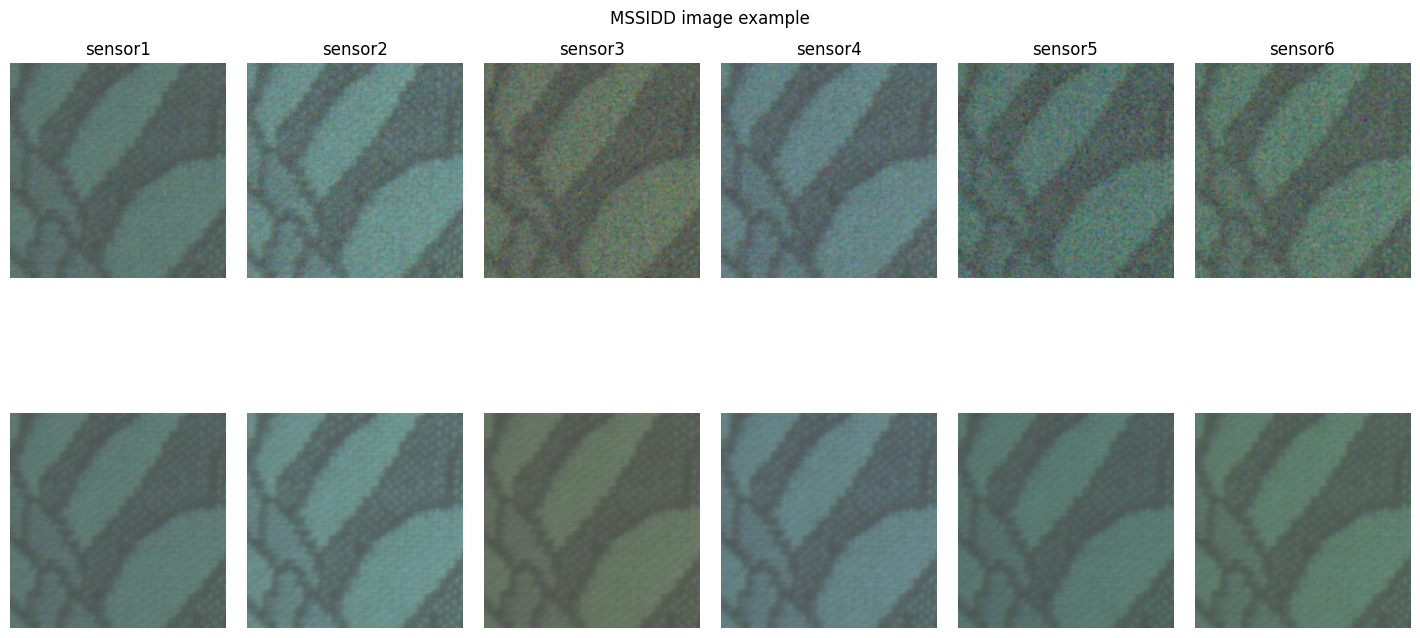

In [8]:
fig, axs = plt.subplots(2, 6, figsize=(14,7))
axs[0,0].set_title('sensor1')
axs[0,1].set_title('sensor2')
axs[0,2].set_title('sensor3')
axs[0,3].set_title('sensor4')
axs[0,4].set_title('sensor5')
axs[0,5].set_title('sensor6')
for i in range(6):
    axs[0,i].imshow(lq[i])
    axs[1,i].imshow(gt[i])
    axs[0,i].axis('off')
    axs[1,i].axis('off')
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0)
fig.suptitle('MSSIDD image example')